In [58]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchinfo

In [59]:
def get_station_locations_SSA(dataset, ds_stations):
    ds_stations.index = ds_stations['LocationID']#sitecode
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Latitude' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_Id'], ['Longitude' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'first 50 percentile', 'last 50 percentile', 'first 90 percentile', 'last 90 percentile']#'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        elif predictor_type == 'MVI' or predictor_type == 'savgol_raw':
            date_columns = []
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

def offset_dates(row, offset_sample):
    row_NDVI = row.loc[[f'NDVI interpolated at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_NDVI.index = [f'NDVI interpolated at day {n}' for n in range(200)]
    row_temp = row.loc[[f't2m at day {offset_sample[row.name] + n}' for n in range(200)]]
    row_temp.index = [f't2m at day {n}' for n in range(200)]
    row_phases = row.loc[['observed time to beginning of emergence', 'observed time to beginning of flowering', 'observed time to yellow ripeness']]
    row_phases = row_phases + np.timedelta64(60 - offset_sample[row.name], 'D')
    return pd.concat([row_NDVI, row_temp, row_phases], axis=0)

def interpolate_columns(ds, numdays, varname, resolution = 4):
    for day in range(numdays):
        upper = int((day // resolution)*resolution + resolution)
        lower = int((day // resolution)*resolution)
        coeff = (day % resolution)/resolution
        #print(lower, upper, coeff)
        #print(ds.loc[:, f'{varname} interpolated at day {upper}'].mean(), ds.loc[:, f'{varname} interpolated at day {lower}'].mean())
        ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day {upper}'] + (1 - coeff)*ds.loc[:, f'{varname} interpolated at day {lower}']
    return ds

def plot_ts_and_phen(ds, fig, ax, numdays = 274):
    for i in ds.index:
        series_at_index = ds.loc[i, :]
        Times = pd.to_datetime(series_at_index['Day of start']) + pd.to_timedelta(np.arange(0, numdays), 'D')
        Values = series_at_index[[f'NDVI interpolated at day {n}' for n in range(numdays)]]
        observation = pd.to_datetime(series_at_index['WC SOS date']) + pd.to_timedelta(series_at_index['observed time to beginning of flowering'], 'D')
        ax.plot(Times, Values)
        ax.axvline(observation)

def combine_columns(ds, Africa=False, numdays = 260):
    list_of_arrays = []
    if Africa:
        metadata_columns = ['year', 'Stations_id', 'lat', 'lon', 'WC SOS date']
        temp_variable = 'temperature'
    else:
        metadata_columns = ['year', 'Stations_id', 'lat', 'lon', 'SOS', 'WC SOS date']
        temp_variable = 't2m'
    for day_index in range(numdays):
        day_array = ds[metadata_columns + [f'NDVI interpolated at day {day_index}', f'{temp_variable} at day {day_index}', 'observed time to beginning of flowering']].set_index(['Stations_id', 'year']).to_xarray()
        day_array = day_array.rename({f'NDVI interpolated at day {day_index}': 'NDVI', f'{temp_variable} at day {day_index}': 't2m'})
        day_array = day_array.expand_dims('time')
        day_array = day_array.assign_coords(time=("time", [day_index]))
        list_of_arrays.append(day_array)
    return xr.concat(list_of_arrays, dim='time')
#ripeness_array#.expand_dims(dim={'time':200})
#ripeness

def MVI_array(da, index_variable = 'time', response_variable = 'NDVI', bins = np.arange(0, 201, 10), original_length = 1):
    binned = da.groupby_bins(index_variable, bins, labels = bins[:-1])
    maxs = binned.max()
    max_locs = binned.map(lambda arr: np.argmax(arr))
    max_locs[index_variable] = max_locs[f'{index_variable}_bins'] + max_locs[response_variable]*original_length
    #print(maxs[f'{index_variable}_bins'].shape, max_locs[index_variable].shape, maxs[response_variable].shape)
    #print(scipy.interpolate.interp1d())
    maxs['MVI NDVI'] = ((f'{index_variable}_bins'), np.interp(maxs[f'{index_variable}_bins'], max_locs[index_variable], maxs[response_variable]))
    return maxs

def to_temp_coords(da, new_coords = np.arange(0, 1701, 10)):
    da['time_index'] = da['time']#
    temps_maxed = da.groupby('t2m').max().set_coords('time_index')
    temps_interpolated = temps_maxed.interp(t2m=new_coords, kwargs={"fill_value": 0})
    return temps_interpolated

def append_frame(df, row):
    df.loc[-1] = row
    df.index = df.index + 1
    df = df.sort_index()
    return df

def convert_to_GDD_time(ds_inputs, numdays = 260, Africa = True, offset = 0, GDD_max = 2800, NDVI_max = 260):
    input_array = combine_columns(ds_inputs, numdays = numdays, Africa=Africa)
    GDD_bins = np.arange(0, GDD_max + 1, 100)
    output_df = pd.DataFrame(columns=['Stations_id', 'year', 'observed time to beginning of flowering GDD'] + [f'NDVI at GDD {GDD_bin}' for GDD_bin in GDD_bins[:-1]])
    count = 0
    for statid in input_array['Stations_id'].values:
        for year in input_array['year'].values:
            input_array_at_year = input_array.sel(Stations_id = statid, year = year)
            if np.isnan(input_array_at_year['t2m'].isel(time = 0)):
                continue
            count += 1
            if count % 20 == 0:
                print(f'#### {count} samples processed ####')
            maxs = MVI_array(input_array_at_year, index_variable = 'time', response_variable = 'NDVI', bins = np.arange(0, NDVI_max + 1, 10), original_length = 1)
            anthesis_day = maxs['observed time to beginning of flowering'].values[0].astype('timedelta64[D]') / np.timedelta64(1, 'D') + offset

            temps_interpolated = to_temp_coords(input_array_at_year, new_coords = np.arange(0, GDD_max + 1, 10))
            maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'NDVI', bins = GDD_bins, original_length = 10)
            anthesis_GDD = input_array_at_year.isel(time = int(anthesis_day))['t2m'].values

            output_df = append_frame(output_df, [statid, year, anthesis_GDD, *maxs['MVI NDVI'].values])
    return output_df

In [60]:
ds_reanalysis_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data_Africa_t2m_PD_SOS.csv')
ds_reanalysis_SSA['Referenzjahr'] = pd.to_datetime(ds_reanalysis_SSA['WC SOS date']).dt.year
ds_reanalysis_SSA = ds_reanalysis_SSA.drop('Unnamed: 0', axis = 1).rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_SSA['year'] = ds_reanalysis_SSA['year'].astype(int)
#ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_SSA_PD_SOS.csv')
#ds_LSP_SSA = ds_LSP_SSA.drop('Unnamed: 0', axis = 1)
ds_LSP_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')
ds_LSP_SSA = ds_LSP_SSA.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_inputs_SSA = pd.merge(ds_LSP_SSA, ds_reanalysis_SSA, on=['Stations_Id', 'year'], how='outer').dropna(how='any')
ds_inputs_SSA['WC SOS date'] = pd.to_datetime(ds_inputs_SSA['WC SOS date'])
date_columns = ['mingrad', 'maxgrad', 
                'minday', 'maxday', 
                'first 50 percentile', 'last 50 percentile', 
                'first 90 percentile', 'last 90 percentile', 
                'observed time to beginning of flowering']
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 0]
#ds_inputs_SSA = interpolate_columns(ds_inputs_SSA, 270, 'NDVI', resolution=8)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 'temperature', numdays = 299, T_base = 0)
stations_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon.csv')
ds_inputs_SSA = get_station_locations_SSA(ds_inputs_SSA, stations_data_lobell)
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Stations_Id':'Stations_id'})
#ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']) - (pd.to_datetime(ds_inputs_SSA['Day of start']) - pd.to_datetime(ds_inputs_SSA['WC SOS date']))
#for column in date_columns:
#    ds_inputs_SSA[column] = pd.to_datetime(ds_inputs_SSA[column])
#    ds_inputs_SSA[column] = ds_inputs_SSA[column] - ds_inputs_SSA['WC SOS date']
#    ds_inputs_SSA[column] = ds_inputs_SSA[column].dt.days 
                

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20968\2764262452.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lat'] = lat
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20968\2764262452.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['lon'] = lon


In [25]:
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv') #_60D_Offset
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')#_60_offset
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')
ds_LSP_DE = ds_LSP_DE.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1).rename(columns={'Stations_id': 'Stations_Id'})
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
#ds_inputs_DE = interpolate_columns(ds_inputs_DE, 195, 'NDVI')
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 200, T_base = 0)
for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
    ds_inputs_DE.loc[:, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs_DE.loc[:, f'observed time to {phase}'])
ds_inputs_DE = ds_inputs_DE.loc[pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days > 0]
#offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs_DE))*30) + 30
#resamples = ds_inputs_DE.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20968\2764262452.py:98: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [26]:
ds_inputs_DE

,Stations_id,year,observed time to beginning of flowering GDD,NDVI at GDD 0,NDVI at GDD 100,NDVI at GDD 200,NDVI at GDD 300,NDVI at GDD 400,NDVI at GDD 500,NDVI at GDD 600,...,t2m at day 196,t2m at day 197,t2m at day 198,t2m at day 199,observed time to beginning of emergence,observed time to beginning of flowering,observed time to yellow ripeness,lat,lon,SOS
13,7521.0,2018,1509.829959,0.400901,0.404578,0.439095,0.457778,0.518035,0.569451,0.568254,...,3196.904771,3203.605051,3212.439040,3220.775173,31 days 00:00:00,94 days 00:00:00,139 days 00:00:00,54.4333,9.8167,104.0
14,7521.0,2019,1538.736099,0.609996,0.555304,0.533966,0.517611,0.548890,0.468524,0.417079,...,2926.525483,2932.669156,2937.972788,2940.067844,15 days 00:00:00,104 days 00:00:00,162 days 00:00:00,54.4333,9.8167,104.0
15,7521.0,2020,1471.351422,0.496279,0.495872,0.497632,0.516172,0.499356,0.503262,0.512900,...,2861.396359,2871.762011,2881.389465,2893.309004,15 days 00:00:00,106 days 00:00:00,181 days 00:00:00,54.4333,9.8167,104.0
16,7521.0,2021,1533.263685,0.537938,0.543918,0.554800,0.521490,0.462877,0.491545,0.525439,...,2840.222284,2851.382911,2862.767097,2874.773178,25 days 00:00:00,106 days 00:00:00,166 days 00:00:00,54.4333,9.8167,104.0
17,7521.0,2022,1390.731635,0.549196,0.534055,0.510411,0.517772,0.522385,0.495189,0.490240,...,2917.898122,2931.161548,2945.772300,2958.884214,23 days 00:00:00,98 days 00:00:00,145 days 00:00:00,54.4333,9.8167,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18499,19585.0,2021,1514.062572,0.502247,0.487473,0.467227,0.451752,0.467914,0.465411,0.466037,...,2899.975224,2909.886236,2920.653107,2933.307471,36 days 00:00:00,102 days 00:00:00,153 days 00:00:00,53.6865,11.0608,104.0
18500,19585.0,2022,1521.797666,0.596066,0.596277,0.582184,0.510510,0.465072,0.465315,0.470059,...,3027.419150,3041.587160,3056.157643,3069.115396,31 days 00:00:00,101 days 00:00:00,159 days 00:00:00,53.6865,11.0608,104.0
18518,19587.0,2017,1462.828935,0.634747,0.607719,0.625885,0.648402,0.706298,0.728450,0.733859,...,3024.683535,3027.851812,3033.678275,3043.706378,27 days 00:00:00,93 days 00:00:00,156 days 00:00:00,48.7091,9.2147,106.0
18579,19700.0,2018,1664.159296,0.388088,0.396694,0.482308,0.557800,0.553796,0.556620,0.562739,...,3157.282720,3165.407463,3172.838253,3179.415116,32 days 00:00:00,100 days 00:00:00,133 days 00:00:00,50.4316,11.9443,107.0


In [13]:
GDD_LSP_list = []
for n in range(0, 1800, 100):
    GDD_LSP_list.append(pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\GDD_time_MODIS_savgol_NDVI_DE_{n}.csv'))

In [17]:
pd.concat(GDD_LSP_list).to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\GDD_time_MODIS_savgol_NDVI_DE.csv')

In [ ]:
fig, ax = plt.subplots()
ds = ds_inputs_DE.loc[ds_inputs_DE['year'] == 2020].iloc[10:13, :]
plot_ts_and_phen(ds, fig, ax)
offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds))*30) + 30
shifted = ds.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]
fig, ax = plt.subplots()
plot_ts_and_phen(shifted, fig, ax, numdays = 200)

In [19]:
import warnings
with warnings.catch_warnings(action="ignore"):
    GDD_time_SSA = convert_to_GDD_time(ds_inputs_SSA)#.loc[:10, :])
    GDD_time_SSA.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\GDD_time_MODIS_savgol_NDVI_SSA.csv')

#### 20 samples processed ####
#### 40 samples processed ####
#### 60 samples processed ####
#### 80 samples processed ####
#### 100 samples processed ####
#### 120 samples processed ####
#### 140 samples processed ####
#### 160 samples processed ####
#### 180 samples processed ####
#### 200 samples processed ####
#### 220 samples processed ####


In [ ]:
#ds_inputs_DE['WC SOS date'] + pd.to_timedelta(np.random.normal(0, 30, ), 'D')#.shape
#pd.DataFrame(columns=[f'NDVI interpolated at day {n}' for n in range(190)] + [f't2m at day {n}' for n in range(190)] + ['observed time to beginning of emergence',
#                                                                                                                        'observed time to beginning of flowering',
#                                                                                                                        'observed time to yellow ripeness',
#                                                                                                                        'lat',
#                                                                                                                        'lon',
#                                                                                                                        'year',
#                                                                                                                        'Stations_id',
#                                                                                                                        'Day of start'])
#ds_inputs_DE.loc[:, f'observed time to yellow ripeness'] 

In [11]:
ds_inputs_SSA.loc[(ds_inputs_SSA['year'] == ds_inputs_SSA['year'][1]) & (ds_inputs_SSA['Stations_id'] == ds_inputs_SSA['Stations_id'][7])]

,year,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,NDVI interpolated at day 48,...,NDVI interpolated at day 261,NDVI interpolated at day 262,NDVI interpolated at day 263,NDVI interpolated at day 265,NDVI interpolated at day 266,NDVI interpolated at day 267,NDVI interpolated at day 268,NDVI interpolated at day 269,lat,lon
7,2004,9.0,2003-09-18,0.386139,0.369279,0.374685,0.402357,0.452124,0.523479,0.601787,...,0.448805,0.446983,0.445162,0.442903,0.442465,0.442028,0.44159,0.441152,-12.73,15.83


In [18]:
#import warnings
#with warnings.catch_warnings(action="ignore"):
#    for n in range(0, 1800, 100):
#        print(n)
#        GDD_time_DE = convert_to_GDD_time(ds_inputs_DE[n:(n + 100)], Africa=False, numdays=190)#.loc[:10, :])
#        GDD_time_DE.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\GDD_time_MODIS_savgol_NDVI_DE_{n}.csv')

In [16]:
len(ds_inputs_DE.loc[pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days > 0])

1720

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1509.8299594484845


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1538.736098934569


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1471.3514219663095


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1533.263685307373


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1390.7316346110842


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1637.9552246081525


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1452.2951543166496


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1305.3289052219232


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1488.932990147458


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1829.432770661378


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1716.2959092070307


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1642.532214052976


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1475.2965443378896


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1438.236993842772


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1418.375030517596


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1644.2481384277535
1551.9709167480685


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


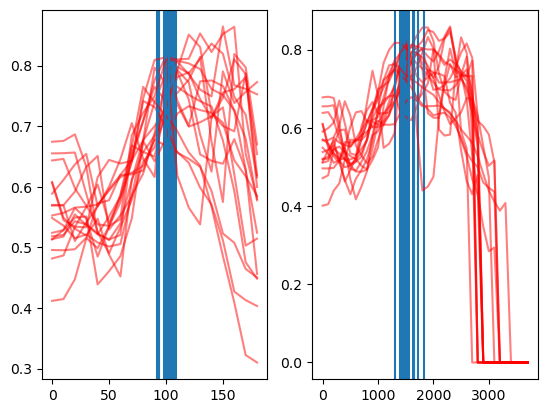

In [72]:
input_array = combine_columns(ds_inputs_DE, numdays = 190)
fig, axs = plt.subplots(1, 2)
for statid in input_array['Stations_id'].values[[0, 10, 20, 30]]:
    for year in input_array['year'].values[0:7]:
        input_array_at_year = input_array.sel(Stations_id = statid, year = year)
        if np.isnan(input_array_at_year['t2m'].isel(time = 0)):
            continue
        time_binned = input_array_at_year.groupby_bins('time', np.arange(0, 191, 10), labels = np.arange(0, 181, 10))
        maxs = MVI_array(input_array_at_year, index_variable = 'time', response_variable = 'NDVI', bins = np.arange(0, 261, 10), original_length = 1)
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_day = maxs['observed time to beginning of flowering'].values[0].astype('timedelta64[D]') / np.timedelta64(1, 'D')# + 60
        axs[0].axvline(anthesis_day)
        temps_interpolated = to_temp_coords(input_array_at_year, new_coords = np.arange(0, 3801, 10))
        maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'NDVI', bins = np.arange(0, 3801, 100), original_length = 10)
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_GDD = input_array_at_year.isel(time = int(anthesis_day))['t2m'].values
        print(anthesis_GDD)
        axs[1].axvline(anthesis_GDD)

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1689.6754638671864


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1397.290045166014


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1553.5950451660071


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1325.9827905273985


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1425.4676770020094


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1434.3735961913958


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1164.2345703124922


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1479.6304802490317


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1470.856263671883


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1376.8971862792982


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1460.858032226565


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1476.0387268066445


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1651.0528417968849


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1487.837044677747


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1258.0944519042948


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1510.4413452148412


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1598.4412041015344


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1512.359283447259


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1866.2387512206926


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1601.1094848632745


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1277.368133545167


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1288.7494506838582


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1348.6339416506576


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1283.9900817873706


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


1238.8834838869575
1438.9318847654836


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


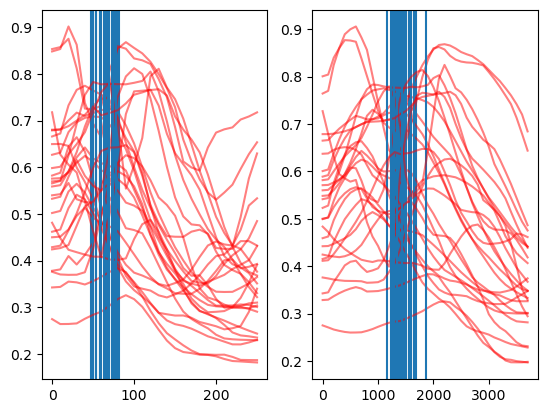

In [80]:
input_array = combine_columns(ds_inputs_SSA, Africa=True)
fig, axs = plt.subplots(1, 2)
for statid in input_array['Stations_id'].values[0:15]:
    for year in input_array['year'].values[0:7]:
        input_array_at_year = input_array.sel(Stations_id = statid, year = year)
        if np.isnan(input_array_at_year['t2m'].isel(time = 0)):
            continue
        time_binned = input_array_at_year.groupby_bins('time', np.arange(0, 261, 10), labels = np.arange(0, 251, 10))
        maxs = MVI_array(input_array_at_year, index_variable = 'time', response_variable = 'NDVI', bins = np.arange(0, 261, 10), original_length = 1)
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_day = maxs['observed time to beginning of flowering'].values[0].astype('timedelta64[D]') / np.timedelta64(1, 'D')# + 60
        axs[0].axvline(anthesis_day)
        temps_interpolated = to_temp_coords(input_array_at_year, new_coords = np.arange(0, 3801, 10))
        maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'NDVI', bins = np.arange(0, 3801, 100), original_length = 10)
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_GDD = input_array_at_year.isel(time = int(anthesis_day))['t2m'].values
        print(anthesis_GDD)
        axs[1].axvline(anthesis_GDD)

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3079.4534057614565


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


2200.1926391597194


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3998.0505859375808


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3691.6206560303526


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3831.216827014219


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3869.998844799837


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


3972.848823974656
3966.3463945801323


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


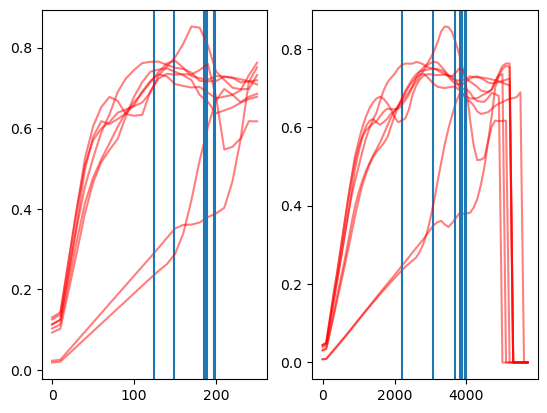

In [128]:
input_array = combine_columns(ds_inputs_SSA, Africa=True)
fig, axs = plt.subplots(1, 2)
for statid in input_array['Stations_id'].values[14:18]:
    for year in input_array['year'].values[0:8]:
        input_array_at_year = input_array.sel(Stations_id = statid, year = year)
        if np.isnan(input_array_at_year['t2m'].isel(time = 0)):
            continue
        #time_binned = input_array_at_year.groupby_bins('time', np.arange(0, 261, 10), labels = np.arange(0, 251, 10))
        maxs = MVI_array(input_array_at_year, index_variable = 'time', response_variable = 'NDVI', bins = np.arange(0, 261, 10), original_length = 1)
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_day = maxs['observed time to beginning of flowering'].values[0].astype('timedelta64[D]') / np.timedelta64(1, 'D') + 60
        axs[0].axvline(anthesis_day)
        temps_interpolated = to_temp_coords(input_array_at_year, new_coords = np.arange(0, 5801, 10))
        maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'NDVI', bins = np.arange(0, 5801, 100), original_length = 10)
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        anthesis_GDD = input_array_at_year.isel(time = int(anthesis_day))['t2m'].values
        print(anthesis_GDD)
        axs[1].axvline(anthesis_GDD)

In [118]:
ds_inputs_DE[[f't2m at day {n}' for n in range(40)]]

,t2m at day 0,t2m at day 1,t2m at day 2,t2m at day 3,t2m at day 4,t2m at day 5,t2m at day 6,t2m at day 7,t2m at day 8,t2m at day 9,...,t2m at day 30,t2m at day 31,t2m at day 32,t2m at day 33,t2m at day 34,t2m at day 35,t2m at day 36,t2m at day 37,t2m at day 38,t2m at day 39
13,8.120025,18.059569,29.009651,43.148896,58.922551,75.258041,86.990699,98.075972,110.265047,120.386071,...,388.857250,406.437293,421.008614,434.840968,448.673814,463.781547,478.991524,495.774339,513.020656,530.199780
14,5.582989,11.889254,20.446489,29.537240,39.396092,48.828206,59.604279,71.302007,84.077289,99.094221,...,302.426799,313.312325,324.791441,338.835062,352.599877,368.123337,383.225915,395.069092,408.613436,421.870142
15,5.267146,13.670102,21.953143,29.333188,37.607707,45.341283,54.088023,63.922006,73.495717,85.568788,...,285.031219,293.690852,303.780914,314.934602,326.304987,339.280484,352.276379,367.057472,382.359506,395.739150
17,7.686438,14.174061,21.383537,29.624032,37.468392,46.445700,54.718552,63.880038,73.126108,80.973721,...,307.113934,321.255574,335.136858,353.676196,373.289777,387.596122,400.395968,414.098788,430.223490,444.675031
180,7.296997,15.450606,24.950505,35.729810,48.951873,64.983208,79.895851,90.229587,100.955544,112.043116,...,370.488706,387.862901,404.477304,418.668252,431.921196,445.542448,460.808685,476.150829,493.279690,511.037745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16576,7.487351,13.972073,21.098421,29.493538,37.027703,44.954177,53.622189,63.168500,73.123220,81.562448,...,331.619823,347.824408,362.883839,380.796488,402.209703,419.472300,433.595346,446.867160,463.385333,479.504659
16629,5.336349,14.176214,23.523366,32.153567,40.724358,48.185761,56.697607,66.300978,76.487602,88.890265,...,304.994553,313.465565,323.989624,335.886594,348.395668,361.928735,374.537240,388.511149,404.477290,418.791705
16631,7.524101,13.911233,20.957387,29.310776,36.999022,44.939226,53.628194,63.383267,73.383235,81.519633,...,319.420106,335.230887,349.681999,367.810769,389.241882,405.356523,418.753283,432.150863,448.454317,463.859783
16690,13.960713,28.807421,45.903367,62.101927,78.616936,93.541383,106.698014,119.689449,128.746936,138.877746,...,424.938206,436.858385,451.337138,466.995563,483.795292,500.123599,516.264644,532.958885,550.853732,569.829682


In [114]:
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data_t2m_60D_Offset.csv')
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE_60_offset.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
ds_inputs_DE = interpolate_columns(ds_inputs_DE, 275, 'NDVI')
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 270, T_base = 0)
for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
    ds_inputs_DE.loc[:, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs_DE.loc[:, f'observed time to {phase}'])
offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs_DE))*30) + 30
ds_inputs_DE.reset_index().apply(lambda row: offset_dates(row, offset_sample), axis=1)#[0]

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_2232\3988289945.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_2232\3988289945.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day

,NDVI interpolated at day 0,NDVI interpolated at day 1,NDVI interpolated at day 2,NDVI interpolated at day 3,NDVI interpolated at day 4,NDVI interpolated at day 5,NDVI interpolated at day 6,NDVI interpolated at day 7,NDVI interpolated at day 8,NDVI interpolated at day 9,...,t2m at day 193,t2m at day 194,t2m at day 195,t2m at day 196,t2m at day 197,t2m at day 198,t2m at day 199,observed time to beginning of emergence,observed time to beginning of flowering,observed time to yellow ripeness
0,0.333545,0.336821,0.340097,0.343373,0.346650,0.357654,0.368658,0.379662,0.390666,0.407313,...,3468.445515,3475.050466,3480.135694,3483.990900,3487.458628,3489.648353,3490.456005,47 days,110 days,155 days
1,0.549200,0.556177,0.553101,0.550026,0.546951,0.543875,0.528567,0.513259,0.497951,0.482642,...,2942.463596,2951.502697,2961.322658,2970.749121,2978.672298,2984.720567,2989.410286,68 days,157 days,215 days
2,0.392703,0.397165,0.400606,0.404046,0.407487,0.410927,0.415942,0.420956,0.425971,0.430985,...,3017.667087,3026.042643,3036.211936,3048.187571,3058.075286,3068.579916,3079.998851,56 days,147 days,222 days
3,0.468531,0.476611,0.484659,0.492706,0.500754,0.508801,0.513409,0.518016,0.522624,0.527231,...,3181.861587,3184.912671,3189.431698,3191.904220,3192.275423,3192.275423,3192.275423,44 days,119 days,166 days
4,0.494674,0.470826,0.446978,0.426717,0.406457,0.386196,0.365935,0.349261,0.332587,0.315913,...,3152.050307,3157.346684,3159.902039,3165.634945,3174.009387,3182.152580,3191.163238,90 days,147 days,191 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.605356,0.598628,0.591900,0.585172,0.570475,0.555777,0.541079,0.526381,0.514140,0.501899,...,3241.091582,3249.274737,3257.093858,3264.003246,3271.868245,3278.495531,3282.151950,66 days,149 days,171 days
998,0.487071,0.500102,0.513132,0.526163,0.529361,0.532559,0.535757,0.538955,0.528868,0.518782,...,3293.029432,3300.122564,3306.340325,3311.322733,3317.539323,3322.937642,3331.019389,33 days,109 days,165 days
999,0.454895,0.486361,0.510460,0.534559,0.558659,0.582758,0.568309,0.553861,0.539413,0.524964,...,3120.960092,3129.805956,3140.990977,3153.090957,3165.813062,3177.189271,3187.818718,80 days,150 days,208 days
1000,0.356988,0.368863,0.380737,0.392612,0.404487,0.415491,0.426495,0.437499,0.448503,0.461262,...,3342.243173,3342.243173,3342.301344,3343.558773,3343.951647,3346.051625,3350.892325,44 days,112 days,145 days


In [178]:
def sample_augmented_frame(ds_inputs):
    series_length = 190
    offset_sample = np.int64(truncnorm.rvs(-1, 1, size=len(ds_inputs))*30) + 30
    #SOS_dates = ds_inputs['WC SOS date'] + pd.to_timedelta(offset_sample, 'D')#.shape
    ds_augmented = ds_inputs.loc[:, ['observed time to beginning of emergence',
                            'observed time to beginning of flowering',
                            'observed time to yellow ripeness',
                            'lat',
                            'lon',
                            'year',
                            'Stations_id',
                            'Day of start']]
    ds_augmented.loc[:, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))#np.array([0 for count in range(len(ds_inputs))])
    ds_augmented.loc[:, [f't2m at day {n}' for n in range(series_length)]] = np.zeros((len(ds_inputs), series_length))
    for row_number, row_index in enumerate(ds_inputs.index):
        print(row_number)
        augmented_start = offset_sample[row_number]
        ds_augmented.loc[row_index, [f'NDVI interpolated at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f'NDVI interpolated at day {n + augmented_start}' for n in range(series_length)]]
        ds_augmented.loc[row_index, [f't2m at day {n}' for n in range(series_length)]] = ds_inputs.loc[row_index, [f't2m at day {n + augmented_start}' for n in range(series_length)]]
        #for n in range(series_length):
        #    
            #ds_augmented.loc[row_index, f'NDVI interpolated at day {n}'] = ds_inputs.loc[row_index, f'NDVI interpolated at day {n + augmented_start}']
            #ds_augmented.loc[row_index, f't2m at day {n}'] = ds_inputs.loc[row_index, f't2m at day {n + augmented_start}']
        for phase in ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']:
            ds_augmented.loc[row_index, f'observed time to {phase}'] = pd.to_timedelta(ds_inputs.loc[row_index, f'observed time to {phase}']) + np.timedelta64(60 - augmented_start, 'D')
    return ds_augmented

In [77]:
#ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data_t2m_60D_Offset.csv')
ds_reanalysis_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\Maize_ML_data2_t2m.csv')
ds_reanalysis_DE = ds_reanalysis_DE.drop('Unnamed: 0', axis = 1)#read_reanalysis()
ds_reanalysis_DE = ds_reanalysis_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_reanalysis_DE['year'] = ds_reanalysis_DE['year'].astype(int)
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\LSP_savgol_raw_MODIS_DE_60_offset.csv')
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_reanalysis_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 0]
ds_inputs_DE = interpolate_columns(ds_inputs_DE, 195, 'NDVI')#275
#ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_2232\3988289945.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_2232\3988289945.py:114: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds.loc[:, f'{varname} interpolated at day {day}'] = coeff*ds.loc[:, f'{varname} interpolated at day

In [8]:
#ds_inputs_DE[['NDVI interpolated at day 100', 'NDVI interpolated at day 101', 'NDVI interpolated at day 102', 'NDVI interpolated at day 103', 'NDVI interpolated at day 104']]
#ds_inputs_SSA['observed time to beginning of flowering']#[['Day of start', 'WC SOS date']]
#pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days.min()

In [28]:
ds_inputs_DE.columns.to_list()

['Stations_id',
 'year',
 'observed time to beginning of flowering GDD',
 'NDVI at GDD 0',
 'NDVI at GDD 100',
 'NDVI at GDD 200',
 'NDVI at GDD 300',
 'NDVI at GDD 400',
 'NDVI at GDD 500',
 'NDVI at GDD 600',
 'NDVI at GDD 700',
 'NDVI at GDD 800',
 'NDVI at GDD 900',
 'NDVI at GDD 1000',
 'NDVI at GDD 1100',
 'NDVI at GDD 1200',
 'NDVI at GDD 1300',
 'NDVI at GDD 1400',
 'NDVI at GDD 1500',
 'NDVI at GDD 1600',
 'NDVI at GDD 1700',
 'NDVI at GDD 1800',
 'NDVI at GDD 1900',
 'NDVI at GDD 2000',
 'NDVI at GDD 2100',
 'NDVI at GDD 2200',
 'NDVI at GDD 2300',
 'NDVI at GDD 2400',
 'NDVI at GDD 2500',
 'NDVI at GDD 2600',
 'NDVI at GDD 2700',
 'WC SOS date',
 't2m at day 0',
 't2m at day 1',
 't2m at day 2',
 't2m at day 3',
 't2m at day 4',
 't2m at day 5',
 't2m at day 6',
 't2m at day 7',
 't2m at day 8',
 't2m at day 9',
 't2m at day 10',
 't2m at day 11',
 't2m at day 12',
 't2m at day 13',
 't2m at day 14',
 't2m at day 15',
 't2m at day 16',
 't2m at day 17',
 't2m at day 18',
 't

In [78]:
skip = 4
numsteps = int(183 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI at GDD {12 + skip*n}' for n in range(numsteps)]].values)
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {skip*n}' for n in range(numsteps)]].values)
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, NDVI_series_DE)), 0, 1)
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].values)

In [34]:
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering']).dt.days

In [54]:
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2200, 100)]].values)
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering GDD'].values)

In [55]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2200, 100)]].values)
NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering GDD'].values)

In [11]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(195)]].values)
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n}' for n in range(195)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].values)

In [50]:
class phen_CNN_1d(nn.Module):
    #def __init__(self):
    #    super().__init__()
        

    #def forward(self, xb):
    #    return self.lin(xb)
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 3, kernel_size=9, padding=4)
        self.conv2 = nn.Conv1d(3, 3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(3, 1, kernel_size=3, padding=1)
        self.lin = nn.Linear(40, 1)
        self.pool = torch.nn.AvgPool1d(kernel_size=183, padding = 0)
    
    def forward(self, xb):
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv1(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        #xb = torch.nn.functional.leaky_relu(self.conv2(xb), negative_slope=0.001)
        #print(xb[0, 0, :])
        xb = torch.nn.functional.leaky_relu(self.conv3(xb), negative_slope=0.001)
        #xb = torch.nn.functional.relu(self.conv3(xb))
        #print(xb[0, :])
        xb = self.pool(xb)
        #print(xb[0, :, :])
        #print(xb[0, :])
        return xb.view(-1, xb.size(1))

def get_model():
    model = phen_CNN_1d()
    return model, optim.SGD(model.parameters(), lr=lr)

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = torch.sqrt(loss_func(model(xb), yb))

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 40)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def plot_train_val_loss(num_epochs, train_losses, val_losses, best_epoch):

    epochs = range(1, num_epochs + 1)
    # Plot Losses
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, train_losses, label='Train Loss')
    ax.plot(epochs, val_losses, label='Val Loss')
    ax.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
    fig.suptitle('Loss vs Epoch')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ymax = min((np.array(val_losses)[:20].max())*1.05, 40)
    ymin = (np.array(val_losses).min())*0.95
    ax.set_ylim([ymin, ymax])
    plt.legend()

    # Show the plots
    plt.tight_layout()

def dl_variance(dl):
    running_var = 0
    running_len = 0
    for xb, yb in dl:
        running_var += torch.var(yb)*(len(yb) - 1)
        running_len += len(yb)
    return running_var/(running_len - 1)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # Variables to store training history
    train_losses = []
    val_losses = []
    best_loss = 10000
    best_epoch = 0
    
    train_var = dl_variance(train_dl)
    val_var = dl_variance(valid_dl)

    for epoch in range(epochs):
        running_loss = 0.0
        running_samples = 0
        model.train()
        running_var = 0
        running_var_val = 0

        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, loss_func, xb, yb, opt)
            #print(batch_loss**2
            running_loss += (batch_loss**2)*batch_len
            running_samples += batch_len
            
            #print(batch_loss, batch_len, running_samples)
        train_loss = np.sqrt(running_loss/running_samples)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
        val_loss = np.sqrt(np.sum(np.multiply(np.power(losses, 2), nums)) / np.sum(nums))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Save the best model (based on validation accuracy)
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch + 1
            #torch.save(model.state_dict(), 'saved_models/best_test.pth')

        # Save the model at the last epoch
        #if epoch == epochs - 1:
        #    torch.save(model.state_dict(), 'saved_models/last_test.pth')

        if epoch % 50 == 0:
            train_r2 = 1 - ((val_loss**2)/val_var)
            val_r2 = 1 - ((train_loss**2)/train_var)
            print(epoch, val_loss, train_loss)
            print(f'R2 on train set: {train_r2}\nR2 on test set: {val_r2}')
    plot_train_val_loss(epochs, train_losses, val_losses, best_epoch)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

def preprocess(x, y, channels = 1):
    if channels == 1:
        return x[:, None, :], y.view(-1, 1)
    else:
        return x, y.view(-1, 1)

def train_test_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(0.8 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [99]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [72]:
#.shape#.min(dim=1)#.shape

torch.return_types.max(
values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
indices=tensor([ 80, 104, 152,  ...,  44,  80, 100]))

In [57]:
bs = 2000
n_channels = 1
skip = 4
numsteps = int(199 // skip)
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {n*skip}' for n in range(numsteps)]].values)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [89]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

0 95.89488220214844 96.00728607177734
R2 on train set: -82.74308776855469
R2 on test set: -92.80066680908203
50 14.659491539001467 13.448308944702148
R2 on train set: -0.957023024559021
R2 on test set: -0.8404875993728638
100 13.602930068969727 12.652789115905762
R2 on train set: -0.6850897073745728
R2 on test set: -0.6291838884353638
150 13.25197696685791 12.32303237915039
R2 on train set: -0.5992614030838013
R2 on test set: -0.5453709363937378
200 12.86106014251709 11.988033294677734
R2 on train set: -0.506300687789917
R2 on test set: -0.46249163150787354
250 11.976181983947754 11.310916900634766
R2 on train set: -0.30615556240081787
R2 on test set: -0.30194664001464844
300 11.717949867248535 11.148158073425293
R2 on train set: -0.2504357099533081
R2 on test set: -0.2647472620010376
350 12.60708236694336 12.763497352600098
R2 on train set: -0.4473956823348999
R2 on test set: -0.6578181982040405
400 11.947916984558105 11.335572242736816
R2 on train set: -0.2999974489212036
R2 on test 

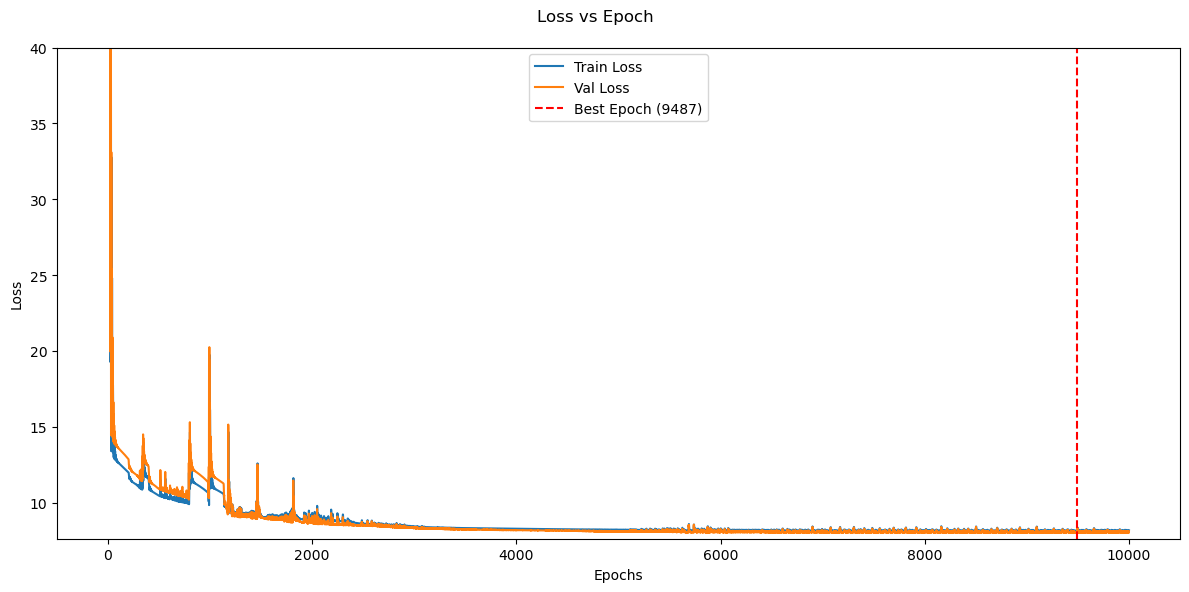

In [80]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 1, kernel_size=5, dilation=6, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(1, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),#nn.Linear(numsteps, 1)#
    Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 10000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl)

In [81]:
torchinfo.summary(model)#.eval()

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv1d: 1-1                            11
├─LeakyReLU: 1-2                         --
├─Conv1d: 1-3                            4
├─LeakyReLU: 1-4                         --
├─AdaptiveAvgPool1d: 1-5                 --
├─Lambda: 1-6                            --
Total params: 15
Trainable params: 15
Non-trainable params: 0

In [82]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")

Parameter name: 0.weight
Parameter value: Parameter containing:
tensor([[[  7.1422,  -2.4835,  -2.7349,   1.2524,  -4.4099],
         [  5.1709,  -0.2092, -10.8349,  -1.1365,  -3.4423]]],
       requires_grad=True)
Parameter name: 0.bias
Parameter value: Parameter containing:
tensor([-40.6502], requires_grad=True)
Parameter name: 2.weight
Parameter value: Parameter containing:
tensor([[[-2.5403, -1.5112, -0.5888]]], requires_grad=True)
Parameter name: 2.bias
Parameter value: Parameter containing:
tensor([111.1209], requires_grad=True)


In [44]:
C1 = list(model.children())[0]
RU1 = list(model.children())[1]
C2 = list(model.children())[2]
RU2 = list(model.children())[3]
AP = list(model.children())[4]

In [37]:
def plot_all_channels(X, fig, ax):
    for channel_index in range(X.shape[0]):
        ax.plot(X[channel_index, :])

In [38]:
def plot_each_layer(TS_model, X):
    layers = list(TS_model.children())
    fig, axs = plt.subplots(len(layers) + 1, 1, figsize = (3, 10))
    plot_all_channels(X, fig, axs[0])
    X_at_layer = X
    for layer_index, layer in enumerate(layers):
        ax = axs[layer_index + 1]
        with torch.no_grad():
            X_at_layer = layer(X_at_layer)
        plot_all_channels(X_at_layer, fig, ax)


In [51]:
X = temp_NDVI_series_DE[0, :, :]
X.shape

torch.Size([2, 45])

In [158]:
NDVI_series_DE.shape

torch.Size([1720, 45])

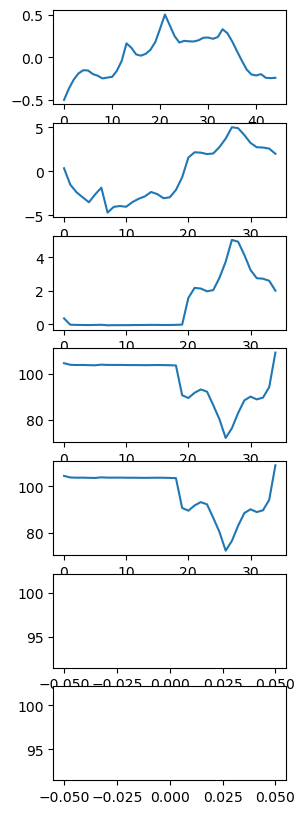

In [164]:
plot_each_layer(model, NDVI_series_DE.view(-1, 1, 45)[6, :, :] - 0.5)

In [72]:
with torch.no_grad():
    print(AP(RU2(C2(RU1(C1(temp_NDVI_series_DE[0, :, :]))))))

tensor([[91.1205]])


0 401.2398681640625 84.30229187011719
R2 on train set: -1608.431396484375
R2 on test set: -69.57164001464844
50 22.255840301513672 16.226760864257812
R2 on train set: -3.951676845550537
R2 on test set: -1.614659309387207
100 13.632790565490723 13.593714714050293
R2 on train set: -0.8579492568969727
R2 on test set: -0.8349647521972656
150 12.802770614624023 12.869356155395508
R2 on train set: -0.6385972499847412
R2 on test set: -0.6446181535720825
200 12.810226440429688 12.209968566894531
R2 on train set: -0.640506386756897
R2 on test set: -0.4804048538208008
250 10.726665496826172 12.422660827636719
R2 on train set: -0.15025413036346436
R2 on test set: -0.5324300527572632
300 10.429513931274414 10.705803871154785
R2 on train set: -0.08740782737731934
R2 on test set: -0.13812506198883057
350 10.195324897766113 10.401710510253906
R2 on train set: -0.03912174701690674
R2 on test set: -0.0743875503540039
400 10.07879638671875 10.305895805358887
R2 on train set: -0.015504002571105957
R2 on 

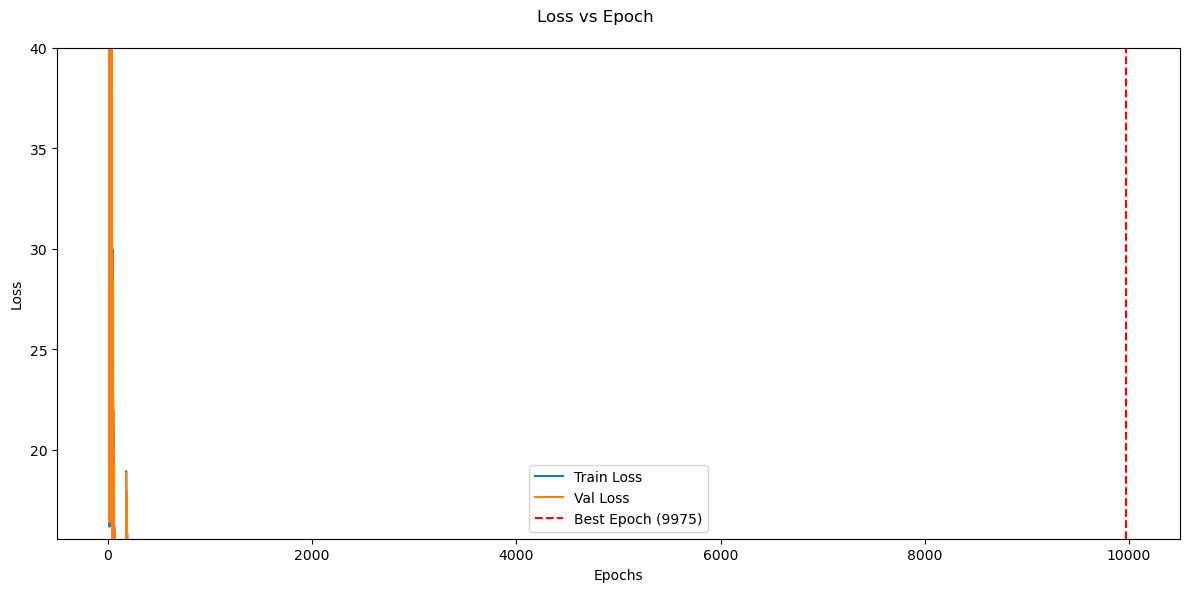

In [109]:
bs = 2000
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=6, padding=7),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 10000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl)

In [57]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=6, padding=7),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(3, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.01
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 2000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 1508.7855224609375 1509.6328521993696
R2 on train set: -99.2655029296875
R2 on test set: -94.73197174072266
50 1499.7254638671875 1500.7818387616142
R2 on train set: -98.06495666503906
R2 on test set: -93.61271667480469
100 1484.878662109375 1485.9390432610844
R2 on train set: -96.11325073242188
R2 on test set: -91.75051879882812
150 1470.0306396484375 1471.095051918697
R2 on train set: -94.1807861328125
R2 on test set: -89.90669250488281


KeyboardInterrupt: 

In [170]:
val_dl.dl.dataset.dataset

In [175]:
for xb, yb in val_dl:
    with torch.no_grad():
        print(torch.cat((model(xb), model(xb))).shape)

torch.Size([688, 1])


In [192]:
def plot_fitted_observed(TS_model, dl):
    list_fitted = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            list_fitted.append(TS_model(xb))
        list_observed.append(yb)
    fitted = torch.cat(list_fitted)
    observed = torch.cat(list_observed)
    comparison_frame = pd.DataFrame({'fitted': fitted.numpy().squeeze(), 'observed': observed.numpy().squeeze()})
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
    fig, ax = plt.subplots()
    sns.regplot(x='fitted', y='observed', data = comparison_frame, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')

In [184]:
observed.numpy().squeeze().shape

(344,)

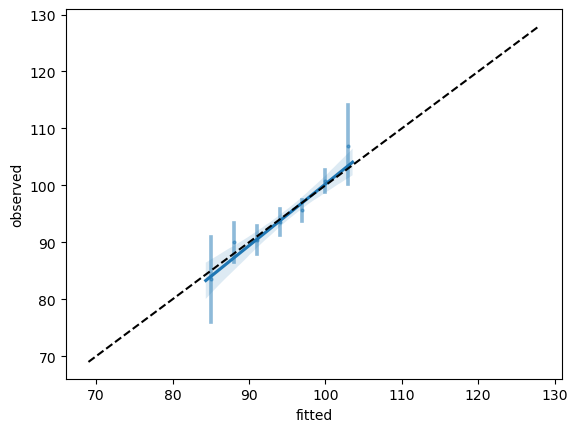

In [193]:
plot_fitted_observed(model, val_dl)


In [49]:
model, opt = get_model()
print(loss_func(model(xb), yb))

In [ ]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n*4}' for n in range(25)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n*4}' for n in range(25)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)

In [58]:
in_channels = 2
out_channels = 4
Kernel_size = 4
c = torch.nn.Conv1d(in_channels, out_channels, Kernel_size)

In [61]:
temp_NDVI_series.shape

torch.Size([240, 2, 25])

In [60]:
c(temp_NDVI_series).shape

torch.Size([240, 4, 22])

In [33]:
ds_inputs_DE.dropna(how='any')[['Day of start', 'WC SOS date']]

# Note to self: start NDVI a bit along

,Day of start,WC SOS date
19,2018-04-03,2018-04-15
20,2019-04-03,2019-04-15
21,2020-04-02,2020-04-14
22,2021-04-03,2021-04-15
23,2022-04-03,2022-04-15
...,...,...
21500,2021-04-03,2021-04-15
21501,2022-04-03,2022-04-15
21519,2017-04-03,2017-04-17
21586,2018-04-03,2018-04-18


In [75]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]


#dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [76]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train, test = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(train, batch_size=len(train), train=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(test, batch_size=len(test), train=False, transform=transform)
trainset = PandasDataset(train)
testset = PandasDataset(test)
 
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 20, kernel_size=4, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(128, 16)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(64, 16)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CNN1d()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 10
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>